In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
from deepcell_tracking.utils import Track, load_trks
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.5.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [2]:
%%time
path_temp_trks = '/data/3T3_nuc_s0-s2.trks'
all_data = [load_trks(path_temp_trks)]

CPU times: user 453 ms, sys: 828 ms, total: 1.28 s
Wall time: 1.29 s


In [3]:
%%time
all_tracks = [Track(tracked_data=d) for d in all_data]

CPU times: user 1min 52s, sys: 8.87 s, total: 2min 1s
Wall time: 1min 47s


In [4]:
%%time
from deepcell_tracking.utils import concat_tracks
track_info = concat_tracks(all_tracks)

CPU times: user 1.06 s, sys: 1.87 s, total: 2.94 s
Wall time: 672 ms


In [5]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for batch in range(X.shape[0]):
        for frame in range(X.shape[1]):
            x = X[batch, frame]
            x = rescale_intensity(x, out_range=(0,1))
            X_rescaled[batch, frame] = x
            
    return X_rescaled

def prepare_dataset(track_info, batch_size=1, buffer_size=256,
                    seed=None, val_split=0.2):
    
    # Merge tracks along the batch axis
    appearances = track_info['appearances']
    
    app_shape = np.shape(appearances)
    appearances = np.swapaxes(appearances, 1,2) #(0,2,1,3,4,5))
    appearances = np.reshape(appearances, [-1, app_shape[1], app_shape[3], app_shape[4], app_shape[5]])
    
    # Normalize appearances
    appearances = norm(appearances)
    
    input_dict = {'appearances': appearances}
    
    output_dict = {'appearances_decoder': appearances}
    
    dataset = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))
    
    # split into train/val
    train_data, val_data = split_dataset(dataset, val_split)
    
    # batch the data
    train_data = train_data.repeat().batch(batch_size)
    val_data = val_data.repeat().batch(batch_size)
    
    # prefetch the data
    train_data = train_data.prefetch(tf.data.AUTOTUNE)
    val_data = val_data.prefetch(tf.data.AUTOTUNE)
    
    return train_data, val_data

In [6]:
train_data, val_data = prepare_dataset(track_info,
                                       batch_size=1)

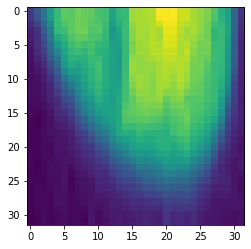

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(track_info['appearances'][0][0][0])

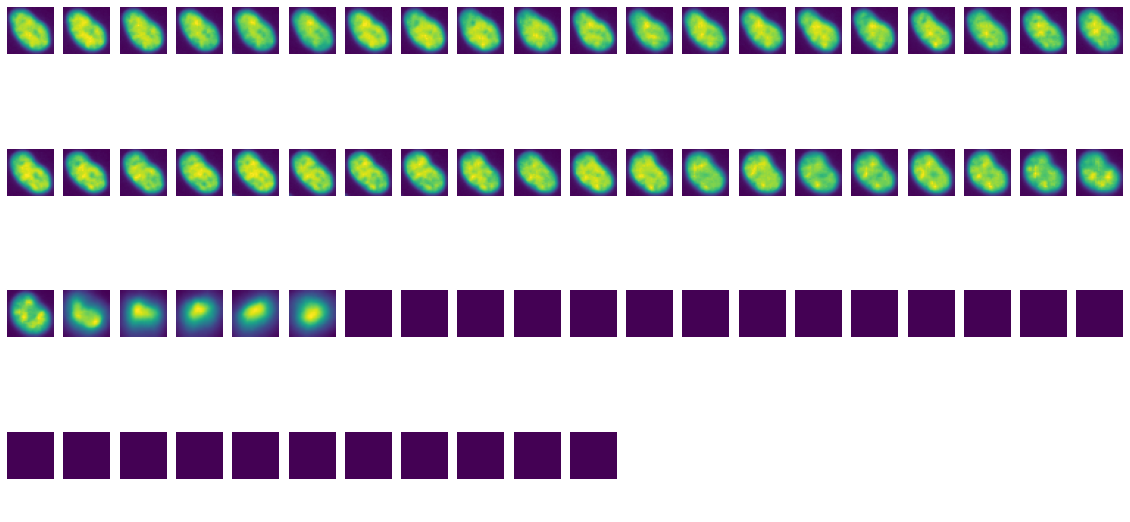

In [8]:
it = iter(train_data)

fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
nxt = it.next()
for j in range(71):
    axes.flatten()[j].imshow(nxt[0]['appearances'][0,j])
    axes.flatten()[j].set_axis_off()

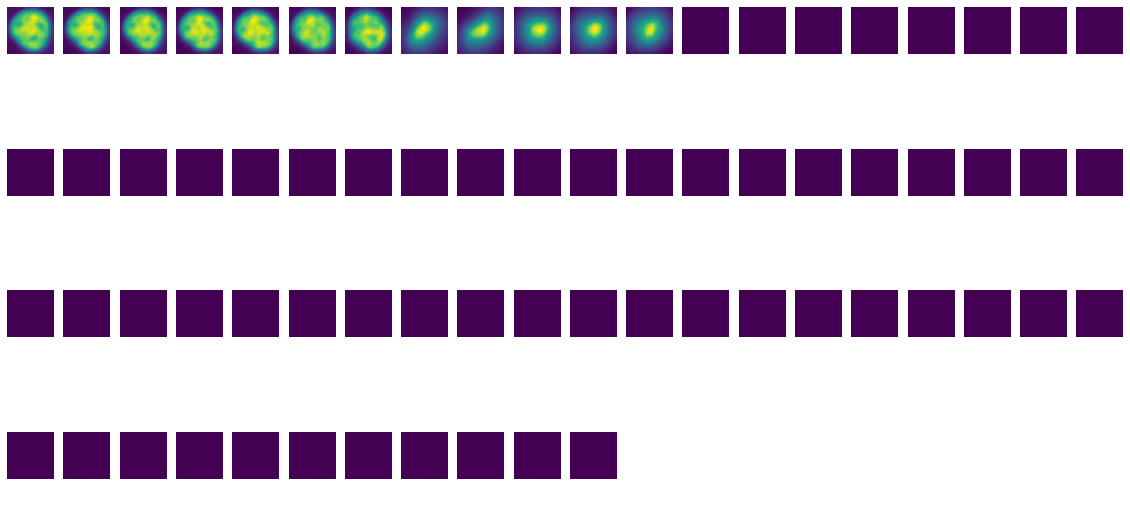

In [10]:
fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
nxt = it.next()
for j in range(71):
    axes.flatten()[j].imshow(nxt[0]['appearances'][0,j])
    axes.flatten()[j].set_axis_off()

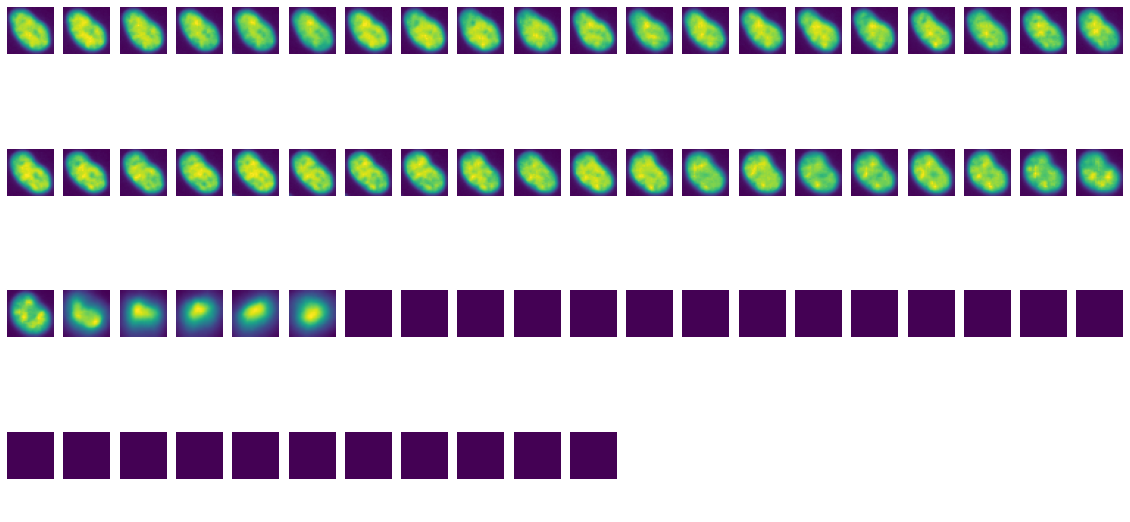

In [11]:
it2 = iter(train_data)

fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
nxt = it2.next()
for j in range(71):
    axes.flatten()[j].imshow(nxt[0]['appearances'][0,j])
    axes.flatten()[j].set_axis_off()

In [12]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for batch in range(X.shape[0]):
        for frame in range(X.shape[1]):
            x = X[batch, frame]
            x = rescale_intensity(x, out_range=(0,1))
            X_rescaled[batch, frame] = x
            
    return X_rescaled

def prepare_dataset(track_info, batch_size=1, buffer_size=256,
                    seed=None, val_split=0.2):
    
    # Merge tracks along the batch axis
    appearances = track_info['appearances']
    
    app_shape = np.shape(appearances)
    appearances = np.swapaxes(appearances, 1,2) #(0,2,1,3,4,5))
    appearances = np.reshape(appearances, [-1, app_shape[1], app_shape[3], app_shape[4], app_shape[5]])
    
    # Normalize appearances
    appearances = norm(appearances)
    
    input_dict = {'appearances': appearances}
    
    output_dict = {'appearances_decoder': appearances}
    
    dataset = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))
    
    dataset = dataset.shuffle(buffer_size, seed=seed)
    
    # split into train/val
    train_data, val_data = split_dataset(dataset, val_split)
    
    # batch the data
    train_data = train_data.repeat().batch(batch_size)
    val_data = val_data.repeat().batch(batch_size)
    
    # prefetch the data
    train_data = train_data.prefetch(tf.data.AUTOTUNE)
    val_data = val_data.prefetch(tf.data.AUTOTUNE)
    
    return train_data, val_data

In [13]:
train_data, val_data = prepare_dataset(track_info,
                                       batch_size=1)

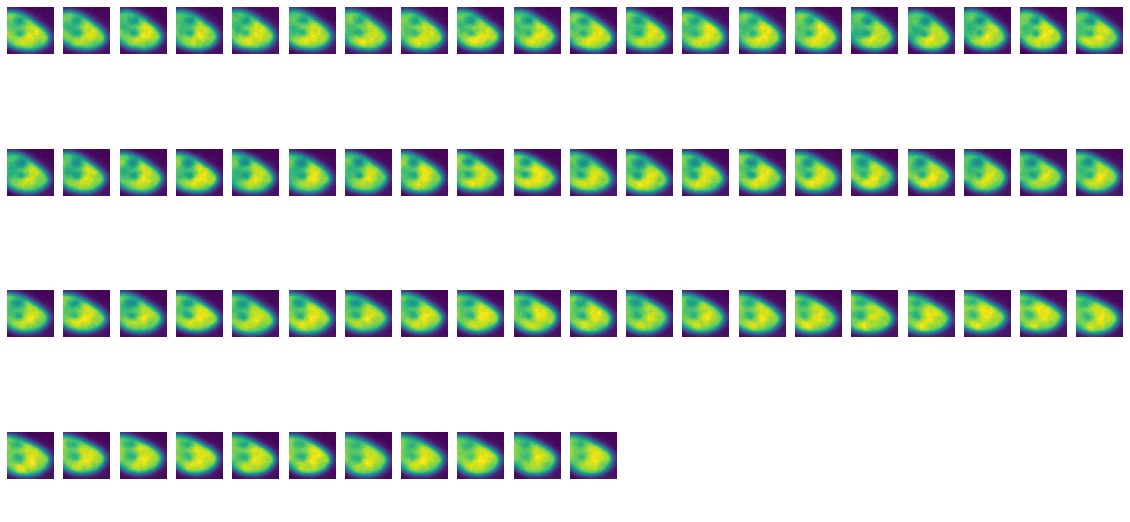

In [14]:
it = iter(train_data)

fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
nxt = it.next()
for j in range(71):
    axes.flatten()[j].imshow(nxt[0]['appearances'][0,j])
    axes.flatten()[j].set_axis_off()

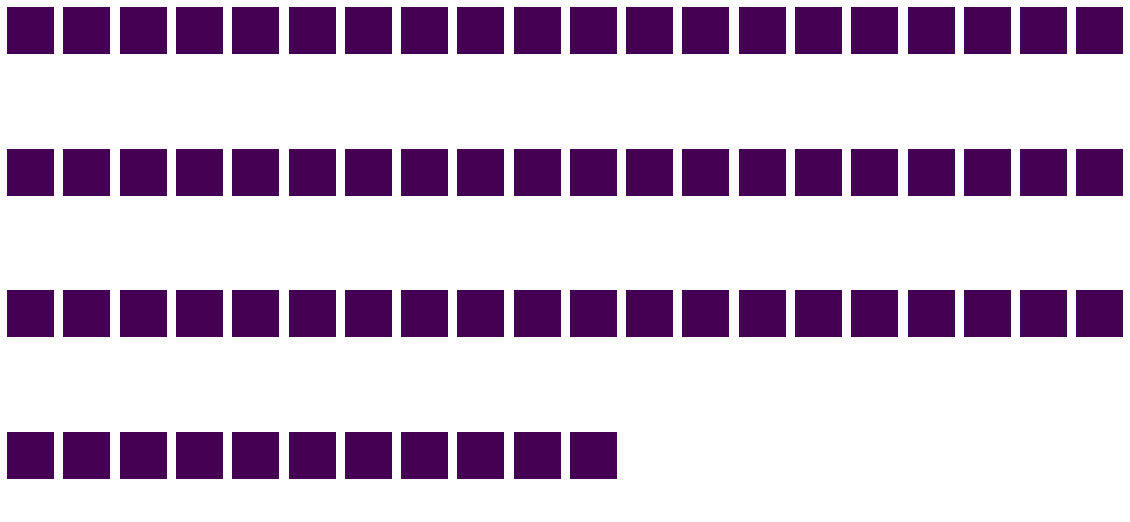

In [15]:
fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
nxt = it.next()
for j in range(71):
    axes.flatten()[j].imshow(nxt[0]['appearances'][0,j])
    axes.flatten()[j].set_axis_off()

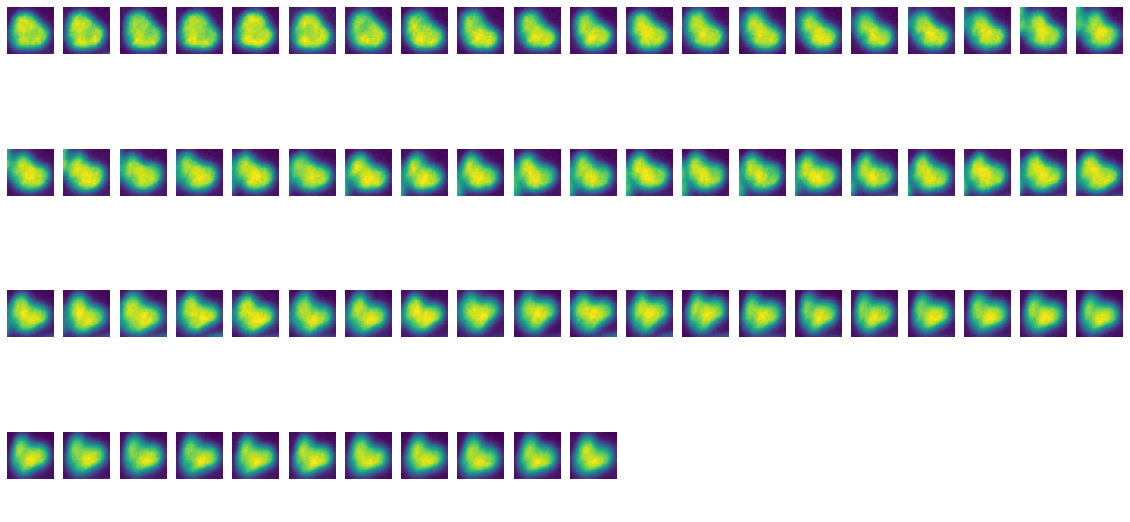

In [16]:
fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
nxt = it.next()
for j in range(71):
    axes.flatten()[j].imshow(nxt[0]['appearances'][0,j])
    axes.flatten()[j].set_axis_off()

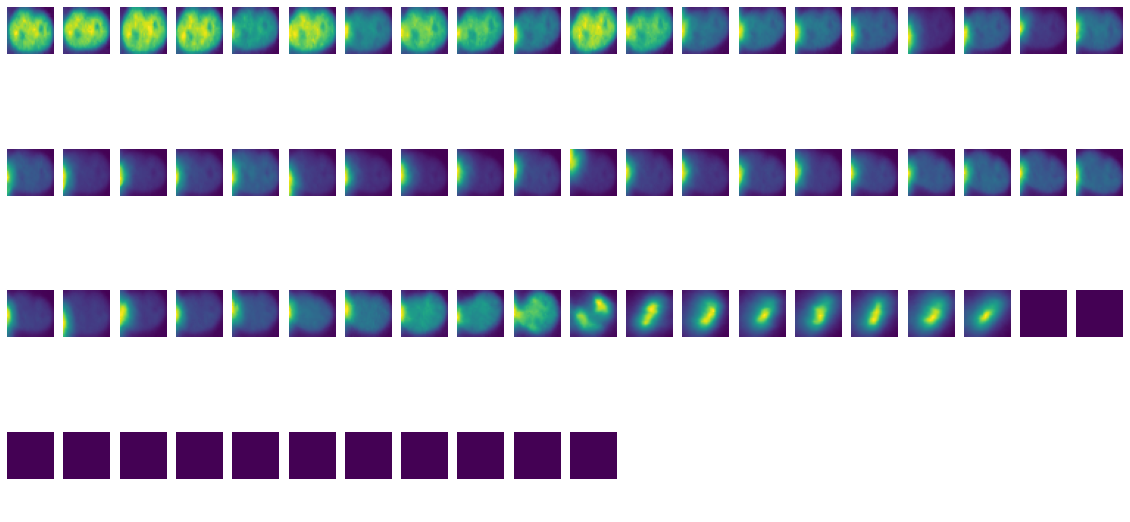

In [17]:
it = iter(train_data)

fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
nxt = it.next()
for j in range(71):
    axes.flatten()[j].imshow(nxt[0]['appearances'][0,j])
    axes.flatten()[j].set_axis_off()

In [20]:
nxt = it.next()

In [21]:
nxt

({'appearances': <tf.Tensor: shape=(1, 71, 32, 32, 1), dtype=float64, numpy=
  array([[[[[0.],
            [0.],
            [0.],
            ...,
            [0.],
            [0.],
            [0.]],
  
           [[0.],
            [0.],
            [0.],
            ...,
            [0.],
            [0.],
            [0.]],
  
           [[0.],
            [0.],
            [0.],
            ...,
            [0.],
            [0.],
            [0.]],
  
           ...,
  
           [[0.],
            [0.],
            [0.],
            ...,
            [0.],
            [0.],
            [0.]],
  
           [[0.],
            [0.],
            [0.],
            ...,
            [0.],
            [0.],
            [0.]],
  
           [[0.],
            [0.],
            [0.],
            ...,
            [0.],
            [0.],
            [0.]]],
  
  
          [[[0.],
            [0.],
            [0.],
            ...,
            [0.],
            [0.],
            [0.]],
